In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost plotly


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
import plotly.express as px


In [4]:
# Load parquet files
risk_df = pd.read_parquet("./Data/risk_model_features.parquet")

print("Risk Data:", risk_df.shape)

risk_df.head()


Risk Data: (48000, 7)


medicine_id  region_id  addiction_score  population  avg_income  \
0         1000       2000                2     1251446     1482837   
1         1000       2000                2     1251446     1482837   
2         1000       2000                2     1251446     1482837   
3         1000       2000                2     1251446     1482837   
4         1000       2000                2     1251446     1482837   

   urban_rural_ratio  reported_abuse_cases  
0               0.71                     3  
1               0.71                     5  
2               0.71                     5  
3               0.71                     5  
4               0.71                     4

In [5]:
# Drop non-numeric or irrelevant columns
risk_num = risk_df.select_dtypes(include=[np.number]).dropna()

# Standardize features
scaler = StandardScaler()
risk_scaled = scaler.fit_transform(risk_num)

print("Scaled risk data shape:", risk_scaled.shape)


Scaled risk data shape: (48000, 7)


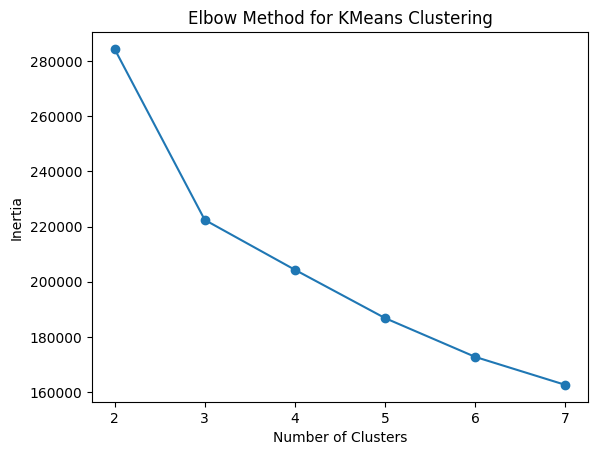

In [6]:
# Determine optimal cluster count (elbow method)
inertia = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(risk_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 8), inertia, marker='o')
plt.title("Elbow Method for KMeans Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [7]:
kmeans = KMeans(n_clusters=3, random_state=42)
risk_df["Cluster"] = kmeans.fit_predict(risk_scaled)

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(risk_scaled)
risk_df["PC1"], risk_df["PC2"] = pca_result[:,0], pca_result[:,1]

fig = px.scatter(
    risk_df, x="PC1", y="PC2", color=risk_df["Cluster"].astype(str),
    title="Risk Clusters (KMeans + PCA)",
    color_discrete_sequence=px.colors.qualitative.Safe
)
fig.show()


In [8]:
iso = IsolationForest(contamination=0.05, random_state=42)
risk_df["Anomaly"] = iso.fit_predict(risk_scaled)
risk_df["Anomaly"] = risk_df["Anomaly"].map({1: "Normal", -1: "Anomaly"})

# Visualize anomalies
fig = px.scatter(
    risk_df, x="PC1", y="PC2", color="Anomaly",
    title="Anomaly Detection in Risk Data (Isolation Forest)",
    color_discrete_sequence=["green", "red"]
)
fig.show()


In [9]:
dbscan = DBSCAN(eps=.8, min_samples=20)
risk_df["DBSCAN_Cluster"] = dbscan.fit_predict(risk_scaled)

fig = px.scatter(
    risk_df, x="PC1", y="PC2", color=risk_df["DBSCAN_Cluster"].astype(str),
    title="DBSCAN Clusters (Risk Data)",
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.show()


In [10]:
for eps in [0.8, 1.0, 1.2, 1.5]:
    for min_samples in [5, 10, 20]:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(risk_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f"eps={eps}, min_samples={min_samples} → clusters={n_clusters}, noise={n_noise}")


eps=0.8, min_samples=5 → clusters=38, noise=2
eps=0.8, min_samples=10 → clusters=38, noise=5
eps=0.8, min_samples=20 → clusters=38, noise=6
eps=1.0, min_samples=5 → clusters=34, noise=1
eps=1.0, min_samples=10 → clusters=34, noise=1
eps=1.0, min_samples=20 → clusters=34, noise=1
eps=1.2, min_samples=5 → clusters=23, noise=1
eps=1.2, min_samples=10 → clusters=23, noise=1
eps=1.2, min_samples=20 → clusters=23, noise=1
eps=1.5, min_samples=5 → clusters=12, noise=0
eps=1.5, min_samples=10 → clusters=12, noise=0
eps=1.5, min_samples=20 → clusters=12, noise=0


In [11]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# # try different k
# scores = {}
# for k in range(2,8):
#     km = KMeans(n_clusters=k, random_state=42)
#     labels = km.fit_predict(risk_scaled)
#     scores[k] = silhouette_score(risk_scaled, labels)

# best_k = max(scores, key=scores.get)
# print(f"Best K = {best_k} with silhouette = {scores[best_k]:.3f}")


In [12]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
labels = gmm.fit_predict(risk_scaled)
risk_df["GMM_Cluster"] = labels


In [13]:
fig = px.scatter(
    risk_df, x="PC1", y="PC2", color=risk_df["GMM_Cluster"].astype(str),
    title="GMM Clusters (Risk Data)",
    color_discrete_sequence=px.colors.qualitative.Bold
)
fig.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

agg = AgglomerativeClustering(n_clusters=3)
labels = agg.fit_predict(risk_scaled)
risk_df["Agglomerative_Cluster"] = labels


